# DU-GD法 (最小二乗問題)

周期性条件あり

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [27]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [28]:
n = 50
m = 100
num_itr = 50
K = 100
adam_lr = 1e-4
max_inner = 40 

A = randn(m,n)
Pinv = (A'*A)^(-1)*A'
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006988054630950127

### ミニバッチ生成関数

In [29]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

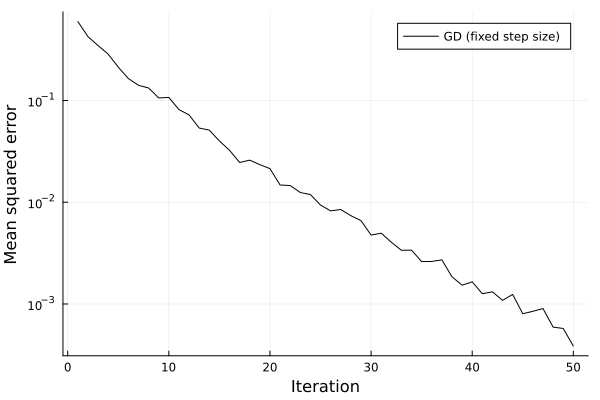

In [30]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*A'*(A*x - y)
    end
    return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [31]:
function DU_GD(max_itr, y, η, T)
    x = zeros(n, K)
    for i in 0:max_itr-1
        k = (i % T)+1
        x = x - η[k]*A'*(A*x - y)
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [32]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [33]:
function train(opt, η, T)
    ps = Flux.params(η) 
    for itr in 1:num_itr
        for i in 1:max_inner
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_est = DU_GD(itr, y, η, T)
                loss(x_opt, x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        y, x_opt = mini_batch(K)
        x_est = DU_GD(itr, y, η, T)
        println(itr, " ", loss(x_opt, x_est))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [34]:
function comp_mse_DUGD(max_itr, η, T)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η, T)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程 $(T=2)$

1 0.735467068336004
2 0.5087009925899285
3 0.32296033611151176
4 0.2363609595612407
5 0.20578869015283272
6 0.16373292674063764
7 0.12083379087199977
8 0.10362852339218248
9 0.062146532456853774
10 0.049172376632948496
11 0.03689408565652155
12 0.027661417651980314
13 0.018144286908099758
14 0.017629706328103026
15 0.010455635873216927
16 0.009140056563732632
17 0.0071661138524311075
18 0.006283442917407633
19 0.004906583247849607
20 0.004674415994492338
21 0.003043339409473664
22 0.0028213602655099146
23 0.0018861684570635336
24 0.002024917321135255
25 0.0015666089579876954
26 0.0011432833753154594
27 0.0008655972486260124
28 0.0008350724921027515
29 0.0006150423456566827
30 0.0005437644856758154
31 0.00043280327760130603
32 0.0003441129692392174
33 0.00020565411638730612
34 0.000259255804409761
35 0.00017383006175406143
36 0.0001496533925964301
37 0.00010141182195209738
38 9.950432966450267e-5
39 7.095310451504208e-5
40 6.598406176400168e-5
41 4.8294021161493885e-5
42 4.4005698041920

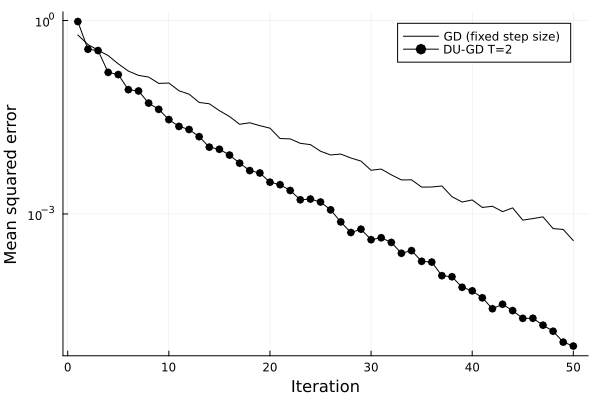

In [35]:
T = 2
η_train = zeros(T) 
opt = ADAM(adam_lr) 
@time train(opt, η_train, T)
DUGD_mse =[comp_mse_DUGD(i, η_train, T) for i in 1:num_itr]
opt_param1 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:o)

### 学習過程 $(T=8)$

1 0.7619841640782654
2 0.5019375902574236
3 0.32901231063492076
4 0.23730528986860602
5 0.16400950655807306
6 0.12648410178409322
7 0.08641798984903608
8 0.06393574923945607
9 0.04112439226920785
10 0.034901154453362324
11 0.023723270845550447
12 0.021094336880629668
13 0.01274825912975195
14 0.00931333133374259
15 0.006577598660684002
16 0.0076133411553703356
17 0.005252010082434475
18 0.00418909764640581
19 0.003066540932973447
20 0.0027578232258004005
21 0.0013799493253301275
22 0.00156229684288425
23 0.0010069375543286855
24 0.0012194095553084553
25 0.0009161091962409076
26 0.0008520833394768759
27 0.000459189845790846
28 0.0004012182212317536
29 0.0002685947281127477
30 0.00022428552898995355
31 0.00024305470864313973
32 0.0002064437720814451
33 0.00010841364374080077
34 0.00010280635687714214
35 8.461593809858841e-5
36 7.75712992089196e-5
37 4.3298488207193135e-5
38 3.511956045507218e-5
39 2.493421055693766e-5
40 2.8659313640707526e-5
41 2.5097416836239303e-5
42 1.972425976555328

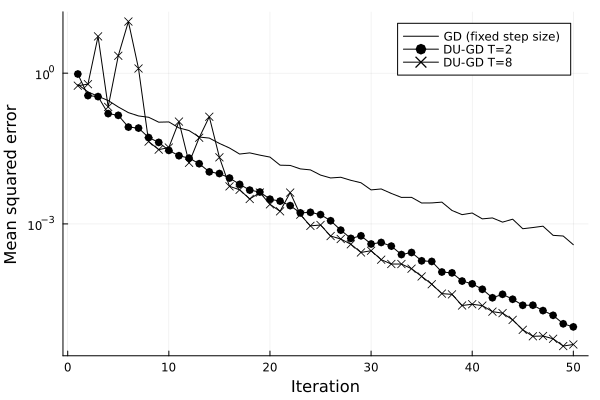

In [36]:
T = 8
η_train = zeros(T) 
opt = ADAM(adam_lr) 
train(opt, η_train, T)
DUGD_mse =[comp_mse_DUGD(i, η_train, T) for i in 1:num_itr]
opt_param2 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:x)

In [37]:
savefig("DU-GD-LMS.pdf")

### 学習後のパラメータのプロット

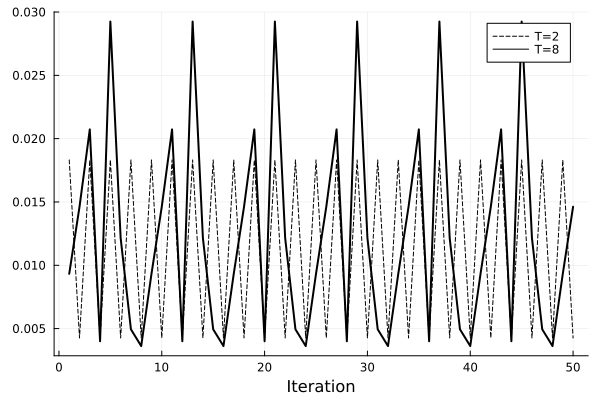

In [38]:
plot(1:num_itr, opt_param1, lw=1, label="T=2", color=:black, ls=:dash, xlabel="Iteration")
plot!(1:num_itr, opt_param2, lw=2, label="T=8", color=:black)

In [39]:
savefig("DU-GD-params.pdf")